In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass


In [2]:
from gemseo import configure_logger
from gemseo.algos.design_space import DesignSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo.disciplines.auto_py import AutoPyDiscipline
from numpy import array
from gemseo_oad_training.unit import convert_from

In [3]:
configure_logger()

<RootLogger root (INFO)>

**Création des disciplines**

In [4]:
l_disciplines = []
l_disciplines.append(AutoPyDiscipline(aerodynamic))
l_disciplines.append(AutoPyDiscipline(approach))
l_disciplines.append(AutoPyDiscipline(battery))
l_disciplines.append(AutoPyDiscipline(climb))
l_disciplines.append(AutoPyDiscipline(engine))
l_disciplines.append(AutoPyDiscipline(fuel_tank))
l_disciplines.append(AutoPyDiscipline(geometry))
l_disciplines.append(AutoPyDiscipline(mass))
l_disciplines.append(AutoPyDiscipline(mission))
l_disciplines.append(AutoPyDiscipline(operating_cost))
l_disciplines.append(AutoPyDiscipline(take_off))
l_disciplines.append(AutoPyDiscipline(total_mass))

**Création du desgin space**

In [5]:
class DesignSpacePB1(DesignSpace):
    def __init__(self):
        super().__init__(name="DSPB1")
        self.add_variable("slst", lower_bound=convert_from("kN",100), upper_bound=convert_from("kN",200), value=convert_from("kN",150.))
        self.add_variable("n_pax", lower_bound=120., upper_bound=180., value=150.)
        self.add_variable("area", lower_bound=convert_from("m2",100.), upper_bound=convert_from("m2",200.), value=convert_from("m2",180.))
        self.add_variable("ar", lower_bound=5, upper_bound=20., value=9.)


In [6]:
from utils import update_default_inputs
x_def = {'fuel_type' : 'liquid_h2', 'engine_type' : 'turbofan', 'design_range' : 5500000}
update_default_inputs(l_disciplines, x_def)

In [7]:
design_space_pb1 = DesignSpacePB1()

In [8]:
design_space_pb1

Name,Lower bound,Value,Upper bound,Type
slst,100000,150000,200000,float
n_pax,120,150,180,float
area,100,180,200,float
ar,5,9,20,float


In [9]:
scenario = MDOScenario(l_disciplines, "mtom", design_space_pb1, formulation_name="MDF")
scenario.add_constraint("tofl", constraint_type="ineq", positive=False,value=convert_from("m", 1900))
scenario.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from("kt", 135))
scenario.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from("ft/min", 300))
scenario.add_constraint("span", constraint_type="ineq", positive=False, value=convert_from("m", 40))
scenario.add_constraint("length", constraint_type="ineq", positive=False, value=convert_from("m", 45))
scenario.add_constraint("fm", constraint_type="ineq", positive=True, value=0)
scenario.add_constraint("fm", constraint_type="ineq", positive=False, value=100)




In [10]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 17:36:33: *** Start MDOScenario execution ***
    INFO - 17:36:33: MDOScenario
    INFO - 17:36:33:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:36:33:    MDO formulation: MDF
    INFO - 17:36:33: Optimization problem:
    INFO - 17:36:33:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:36:33:    with respect to ar, area, n_pax, slst
    INFO - 17:36:33:    subject to constraints:
    INFO - 17:36:33:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:36:33:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:36:33:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:36:33:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:36:33:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:36:33:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:36:33:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:36:33:    over the design space:
    INFO 

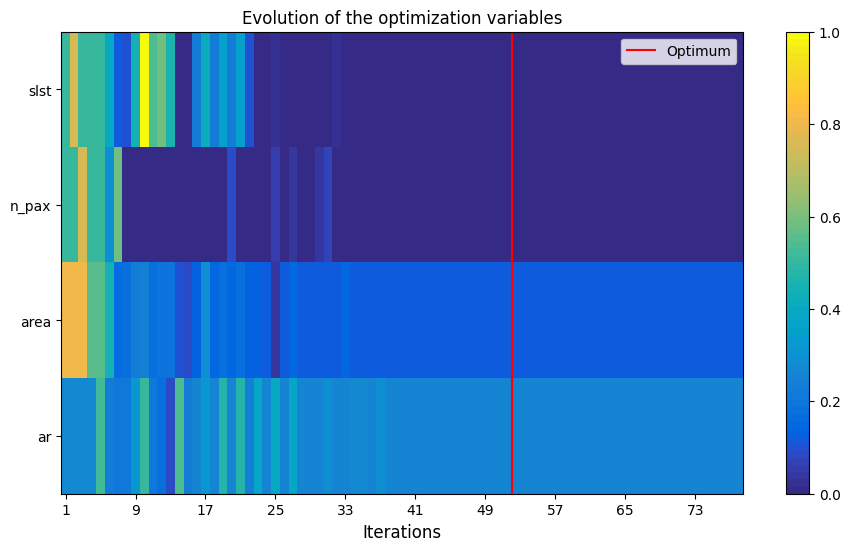

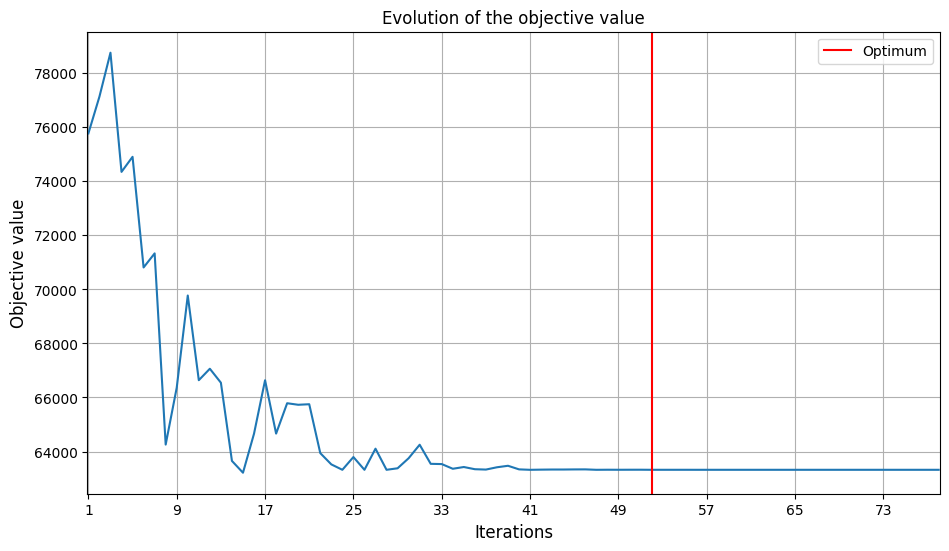

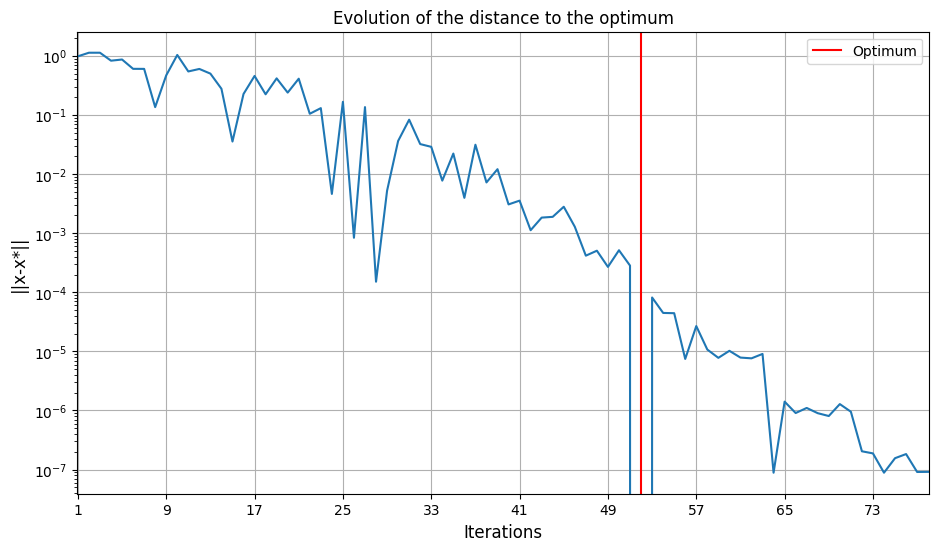

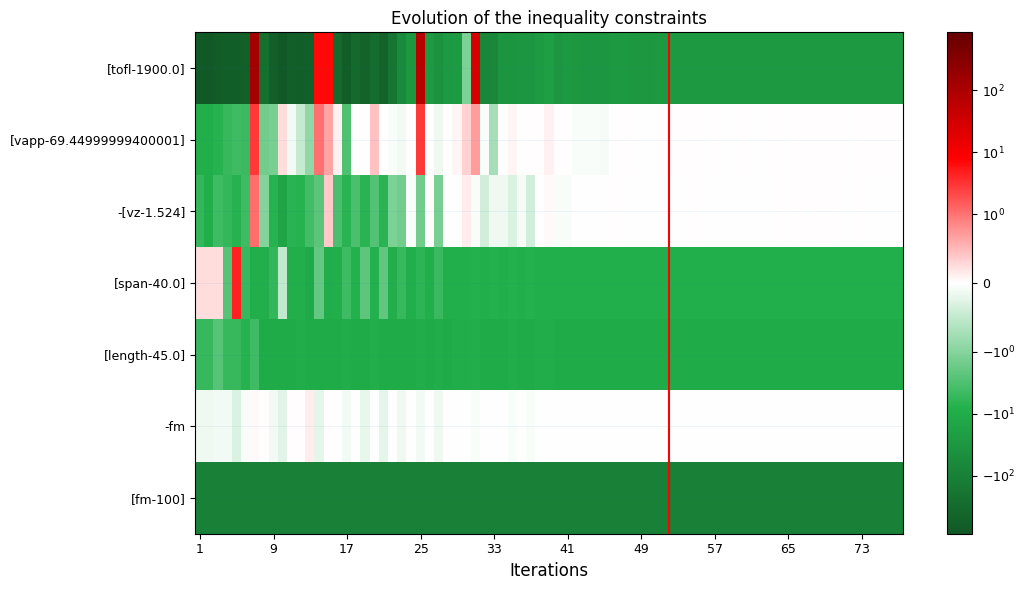

In [11]:
scenario.post_process(post_name="OptHistoryView", save=False, show=True)

Pour la suite : utiliser à la place des discipline s, smaple_discplines() -> "OT_OPT_LHS"  ou sobol ou halton
renvoye une surogate discpiline et remplacer dans MDO scenario la liste des discplines par la sugorate discpline

Surrogate

In [12]:
from gemseo.disciplines.surrogate import SurrogateDiscipline
from gemseo import sample_disciplines

In [13]:
training_dataset = sample_disciplines(l_disciplines, design_space_pb1, ["mtom", "tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_OPT_LHS", n_samples=20)

    INFO - 17:36:35: *** Start Sampling execution ***
    INFO - 17:36:35: Sampling
    INFO - 17:36:35:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:36:35:    MDO formulation: MDF
    INFO - 17:36:35: Running the algorithm OT_OPT_LHS:
    INFO - 17:36:35:    100%|██████████| 20/20 [00:00<00:00, 300.09 it/sec]
    INFO - 17:36:35: *** End Sampling execution (time: 0:00:00.072096) ***


In [14]:
test_dataset = sample_disciplines(l_disciplines, design_space_pb1, ["mtom", "tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_FULLFACT", n_samples=30)

    INFO - 17:36:35: *** Start Sampling execution ***
    INFO - 17:36:35: Sampling
    INFO - 17:36:35:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:36:35:    MDO formulation: MDF
    INFO - 17:36:35: Running the algorithm OT_FULLFACT:
    INFO - 17:36:35:    100%|██████████| 16/16 [00:00<00:00, 265.10 it/sec] not exist; use 16 samples instead, i.e. the largest 4-th integer power less than 30.
    INFO - 17:36:35: *** End Sampling execution (time: 0:00:00.062975) ***


In [15]:
# Liste des surrogate models à tester
metamodels = [
    'GaussianProcessRegressor',
    'GradientBoostingRegressor',
    'LinearRegressor',
    'MLPRegressor',
    'PolynomialRegressor', 
    'RandomForestRegressor',
    'RBFRegressor'
]

results = {}

for model_name in metamodels:
    print(f"model: {model_name}")
    design_space_pb1 = DesignSpacePB1()

    # Créer la discipline de substitution
    surrogate_discipline = SurrogateDiscipline(model_name, training_dataset)

    # Définir un scénario MDO avec cette discipline
    scenario_surrogate = MDOScenario(
        [surrogate_discipline],
        formulation_name="MDF",
        objective_name="mtom",
        design_space=design_space_pb1
    )

    # Ajouter les contraintes
    scenario_surrogate.add_constraint("tofl", constraint_type="ineq", positive=False, value=convert_from("m", 1900))
    scenario_surrogate.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from("kt", 135))
    scenario_surrogate.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from("ft/min", 300))
    scenario_surrogate.add_constraint("span", constraint_type="ineq", positive=False, value=convert_from("m", 40))
    scenario_surrogate.add_constraint("length", constraint_type="ineq", positive=False, value=convert_from("m", 45))
    scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=True, value=0)
    scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=False, value=100)

    # Exécuter l'optimisation
    scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    # Évaluer la qualité via R² en validation croisée
    r2 = surrogate_discipline.get_error_measure("R2Measure")
    r2_result = r2.compute_test_measure(test_dataset, as_dict=True)

    results[model_name] = r2_result
    print(f" {model_name} -> R² (CV): {r2_result}")

# Affichage final des résultats
print("\n Résultats du benchmark R² :")
for model, score in results.items():
    print(f"{model:12} : {score}")


model: GaussianProcessRegressor


 WARNING - 17:36:35: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:36:35: *** Start MDOScenario execution ***
    INFO - 17:36:35: MDOScenario
    INFO - 17:36:35:    Disciplines: GPR_Sampling
    INFO - 17:36:35:    MDO formulation: MDF
    INFO - 17:36:35: Optimization problem:
    INFO - 17:36:35:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:36:35:    with respect to ar, area, n_pax, slst
    INFO - 17:36:35:    subject to constraints:
    INFO - 17:36:35:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:36:35:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:36:35:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:36:35:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:36:35:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:36:35:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:36:35:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:36:35:    over the design space:
    INFO - 17:36:35:       +-

 GaussianProcessRegressor -> R² (CV): {'fm': array([0.94139312]), 'length': array([0.91958428]), 'mtom': array([0.88112945]), 'span': array([0.9289248]), 'tofl': array([0.78557349]), 'vapp': array([0.94008219]), 'vz': array([0.89731673])}
model: GradientBoostingRegressor


 WARNING - 17:36:36: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:36:36: *** Start MDOScenario execution ***
    INFO - 17:36:36: MDOScenario
    INFO - 17:36:36:    Disciplines: GradientBoostingRegressor_Sampling
    INFO - 17:36:36:    MDO formulation: MDF
    INFO - 17:36:36: Optimization problem:
    INFO - 17:36:36:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:36:36:    with respect to ar, area, n_pax, slst
    INFO - 17:36:36:    subject to constraints:
    INFO - 17:36:36:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:36:36:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:36:36:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:36:36:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:36:36:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:36:36:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:36:36:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:36:36:    over the design space:
    INF

 GradientBoostingRegressor -> R² (CV): {'fm': array([0.94699601]), 'length': array([0.98631455]), 'mtom': array([0.78726467]), 'span': array([0.9329913]), 'tofl': array([0.55913785]), 'vapp': array([0.8978902]), 'vz': array([0.80128136])}
model: LinearRegressor


    INFO - 17:36:36:    100%|██████████| 100/100 [00:00<00:00, 249.60 it/sec, obj=6.42e+4]
    INFO - 17:36:36: Optimization result:
    INFO - 17:36:36:    Optimizer info:
    INFO - 17:36:36:       Status: None
    INFO - 17:36:36:       Message: Maximum number of iterations reached. GEMSEO stopped the driver.
    INFO - 17:36:36:       Number of calls to the objective function by the optimizer: 102
    INFO - 17:36:36:    Solution:
    INFO - 17:36:36:       The solution is feasible.
    INFO - 17:36:36:       Objective: 64169.18335565571
    INFO - 17:36:36:       Standardized constraints:
    INFO - 17:36:36:          -[vz-1.524] = -0.19299669229950767
    INFO - 17:36:36:          -fm = 1.6299832779908422e-05
    INFO - 17:36:36:          [fm-100] = -100.00001629983278
    INFO - 17:36:36:          [length-45.0] = -10.249975927735122
    INFO - 17:36:36:          [span-40.0] = -7.845413855244637
    INFO - 17:36:36:          [tofl-1900.0] = -100.94953191086256
    INFO - 17:36:36

 LinearRegressor -> R² (CV): {'fm': array([0.97346181]), 'length': array([1.]), 'mtom': array([0.97264121]), 'span': array([0.96030547]), 'tofl': array([0.79441423]), 'vapp': array([0.96249728]), 'vz': array([0.909829])}
model: MLPRegressor


    INFO - 17:36:37:     76%|███████▌  | 76/100 [00:00<00:00, 239.60 it/sec, obj=6.63e+4]
    INFO - 17:36:37: Optimization result:
    INFO - 17:36:37:    Optimizer info:
    INFO - 17:36:37:       Status: None
    INFO - 17:36:37:       Message: Successive iterates of the objective function are closer than ftol_rel or ftol_abs. GEMSEO stopped the driver.
    INFO - 17:36:37:       Number of calls to the objective function by the optimizer: 77
    INFO - 17:36:37:    Solution:
    INFO - 17:36:37:       The solution is feasible.
    INFO - 17:36:37:       Objective: 66260.06765175471
    INFO - 17:36:37:       Standardized constraints:
    INFO - 17:36:37:          -[vz-1.524] = -2.012365283513769
    INFO - 17:36:37:          -fm = 4.755843225740302e-17
    INFO - 17:36:37:          [fm-100] = -100.0
    INFO - 17:36:37:          [length-45.0] = -8.886925952941752
    INFO - 17:36:37:          [span-40.0] = -5.760415656803296
    INFO - 17:36:37:          [tofl-1900.0] = -438.2559108

 MLPRegressor -> R² (CV): {'fm': array([0.88668922]), 'length': array([0.964245]), 'mtom': array([0.918288]), 'span': array([0.86912483]), 'tofl': array([0.54168529]), 'vapp': array([0.69823013]), 'vz': array([0.88199478])}
model: PolynomialRegressor


    INFO - 17:36:37:    100%|██████████| 100/100 [00:00<00:00, 198.73 it/sec, obj=6.34e+4]
    INFO - 17:36:37: Optimization result:
    INFO - 17:36:37:    Optimizer info:
    INFO - 17:36:37:       Status: None
    INFO - 17:36:37:       Message: Maximum number of iterations reached. GEMSEO stopped the driver.
    INFO - 17:36:37:       Number of calls to the objective function by the optimizer: 102
    INFO - 17:36:37:    Solution:
    INFO - 17:36:37:       The solution is feasible.
    INFO - 17:36:37:       Objective: 63403.4186890301
    INFO - 17:36:37:       Standardized constraints:
    INFO - 17:36:37:          -[vz-1.524] = 6.733816638293533e-06
    INFO - 17:36:37:          -fm = -0.07419082071569656
    INFO - 17:36:37:          [fm-100] = -99.9258091792843
    INFO - 17:36:37:          [length-45.0] = -10.25
    INFO - 17:36:37:          [span-40.0] = -7.307812154932776
    INFO - 17:36:37:          [tofl-1900.0] = -36.5736966251925
    INFO - 17:36:37:          [vapp-69

 PolynomialRegressor -> R² (CV): {'fm': array([0.95398375]), 'length': array([1.]), 'mtom': array([0.96977271]), 'span': array([0.99849626]), 'tofl': array([0.97005691]), 'vapp': array([0.99552138]), 'vz': array([0.97762894])}
model: RandomForestRegressor


    INFO - 17:36:38:     59%|█████▉    | 59/100 [00:00<00:00, 122.30 it/sec, obj=6.84e+4]
    INFO - 17:36:38: Optimization result:
    INFO - 17:36:38:    Optimizer info:
    INFO - 17:36:38:       Status: None
    INFO - 17:36:38:       Message: Successive iterates of the objective function are closer than ftol_rel or ftol_abs. GEMSEO stopped the driver.
    INFO - 17:36:38:       Number of calls to the objective function by the optimizer: 60
    INFO - 17:36:38:    Solution:
    INFO - 17:36:38:       The solution is feasible.
    INFO - 17:36:38:       Objective: 68430.71738634883
    INFO - 17:36:38:       Standardized constraints:
    INFO - 17:36:38:          -[vz-1.524] = -5.7931417890355155
    INFO - 17:36:38:          -fm = -0.22024644955001488
    INFO - 17:36:38:          [fm-100] = -99.77975355044998
    INFO - 17:36:38:          [length-45.0] = -8.610448565135691
    INFO - 17:36:38:          [span-40.0] = -0.34332057868411425
    INFO - 17:36:38:          [tofl-1900.0] 

 RandomForestRegressor -> R² (CV): {'fm': array([0.64649125]), 'length': array([0.68994861]), 'mtom': array([0.59906408]), 'span': array([0.6537324]), 'tofl': array([0.35762305]), 'vapp': array([0.5710874]), 'vz': array([0.44933244])}
model: RBFRegressor


    INFO - 17:36:38:    100%|██████████| 100/100 [00:00<00:00, 223.26 it/sec, obj=6.49e+4]
    INFO - 17:36:38: Optimization result:
    INFO - 17:36:38:    Optimizer info:
    INFO - 17:36:38:       Status: None
    INFO - 17:36:38:       Message: Maximum number of iterations reached. GEMSEO stopped the driver.
    INFO - 17:36:38:       Number of calls to the objective function by the optimizer: 102
    INFO - 17:36:38:    Solution:
    INFO - 17:36:38:       The solution is feasible.
    INFO - 17:36:38:       Objective: 64883.81628702999
    INFO - 17:36:38:       Standardized constraints:
    INFO - 17:36:38:          -[vz-1.524] = -1.5199964590387043
    INFO - 17:36:38:          -fm = -0.11474483469783188
    INFO - 17:36:38:          [fm-100] = -99.88525516530217
    INFO - 17:36:38:          [length-45.0] = -9.680679503994305
    INFO - 17:36:38:          [span-40.0] = -5.251911727579099
    INFO - 17:36:38:          [tofl-1900.0] = -131.5615799217269
    INFO - 17:36:38:     

 RBFRegressor -> R² (CV): {'fm': array([0.95040416]), 'length': array([0.94320235]), 'mtom': array([0.91488687]), 'span': array([0.94043722]), 'tofl': array([0.80399712]), 'vapp': array([0.94271631]), 'vz': array([0.91922279])}

 Résultats du benchmark R² :
GaussianProcessRegressor : {'fm': array([0.94139312]), 'length': array([0.91958428]), 'mtom': array([0.88112945]), 'span': array([0.9289248]), 'tofl': array([0.78557349]), 'vapp': array([0.94008219]), 'vz': array([0.89731673])}
GradientBoostingRegressor : {'fm': array([0.94699601]), 'length': array([0.98631455]), 'mtom': array([0.78726467]), 'span': array([0.9329913]), 'tofl': array([0.55913785]), 'vapp': array([0.8978902]), 'vz': array([0.80128136])}
LinearRegressor : {'fm': array([0.97346181]), 'length': array([1.]), 'mtom': array([0.97264121]), 'span': array([0.96030547]), 'tofl': array([0.79441423]), 'vapp': array([0.96249728]), 'vz': array([0.909829])}
MLPRegressor : {'fm': array([0.88668922]), 'length': array([0.964245]), 'mto

In [16]:
# Enregistrement des résultats dans un fichier CSV
import os
import csv

os.makedirs("results_pb1_usecase2", exist_ok=True)
csv_path = "results_pb1_usecase2/benchmark.csv"
all_outputs = sorted({key for model in results.values() for key in model})

# Écriture CSV
with open(csv_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    
    # En-tête
    writer.writerow(["Model"] + all_outputs)
    
    for model_name, output_scores in results.items():
        row = [model_name]
        for output in all_outputs:
            value = output_scores.get(output)
            if value is not None:
                row.append(round(float(value), 6))  
            else:
                row.append("N/A")
        writer.writerow(row)

In [17]:
surrogate_discipline = SurrogateDiscipline("PolynomialRegressor", training_dataset)

In [18]:
scenario_surrogate = MDOScenario([surrogate_discipline], "mtom", design_space_pb1, formulation_name="MDF")
scenario_surrogate.add_constraint("tofl", constraint_type="ineq", positive=False,value=convert_from("m", 1900))
scenario_surrogate.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from("kt", 135))
scenario_surrogate.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from("ft/min", 300))
scenario_surrogate.add_constraint("span", constraint_type="ineq", positive=False, value=convert_from("m", 40))
scenario_surrogate.add_constraint("length", constraint_type="ineq", positive=False, value=convert_from("m", 45))
scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=True, value=0)
scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=False, value=100)
design_space_pb1 = DesignSpacePB1()




 WARNING - 17:36:39: No coupling in MDA, switching chain_linearize to True.


In [19]:
scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 17:36:39: *** Start MDOScenario execution ***
    INFO - 17:36:39: MDOScenario
    INFO - 17:36:39:    Disciplines: PolyReg_Sampling
    INFO - 17:36:39:    MDO formulation: MDF
    INFO - 17:36:39: Optimization problem:
    INFO - 17:36:39:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:36:39:    with respect to ar, area, n_pax, slst
    INFO - 17:36:39:    subject to constraints:
    INFO - 17:36:39:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:36:39:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:36:39:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:36:39:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:36:39:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:36:39:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:36:39:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:36:39:    over the design space:
    INFO - 17:36:39:       +-------+-------------+-------------------+-------------+-------+
    INFO

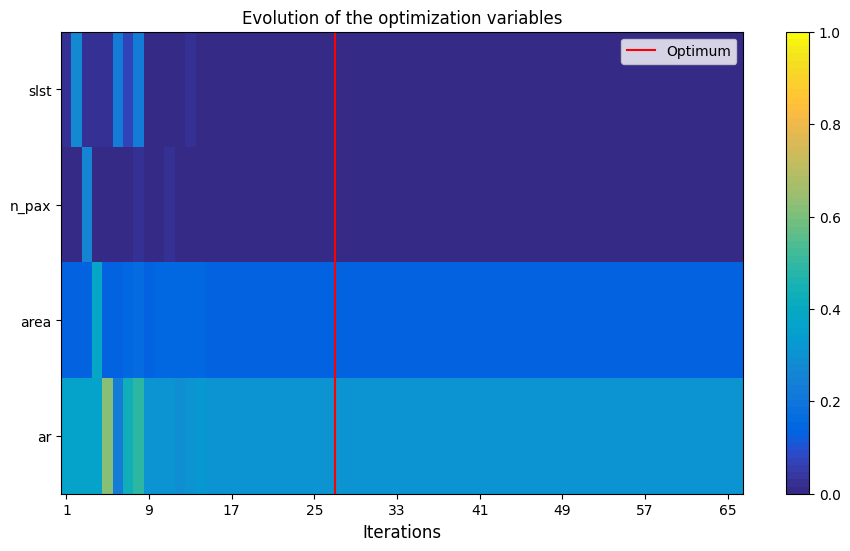

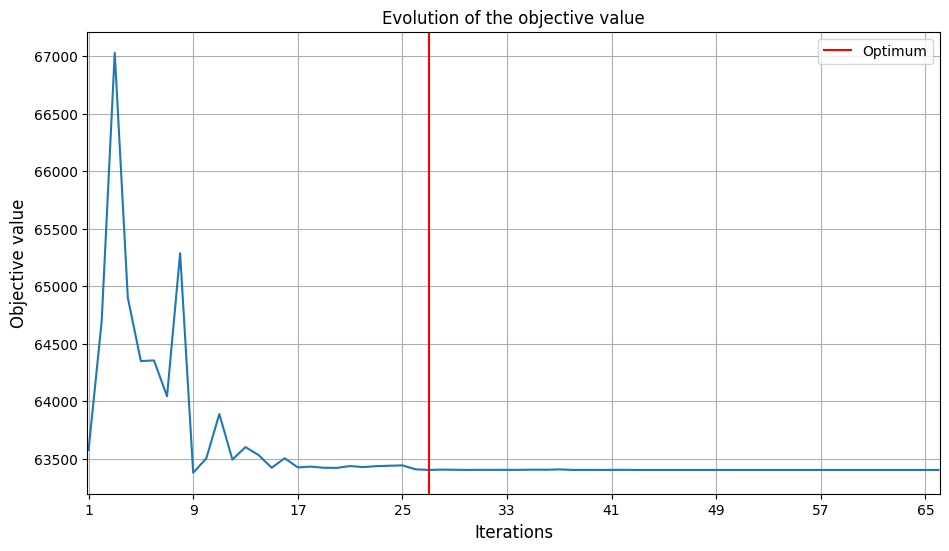

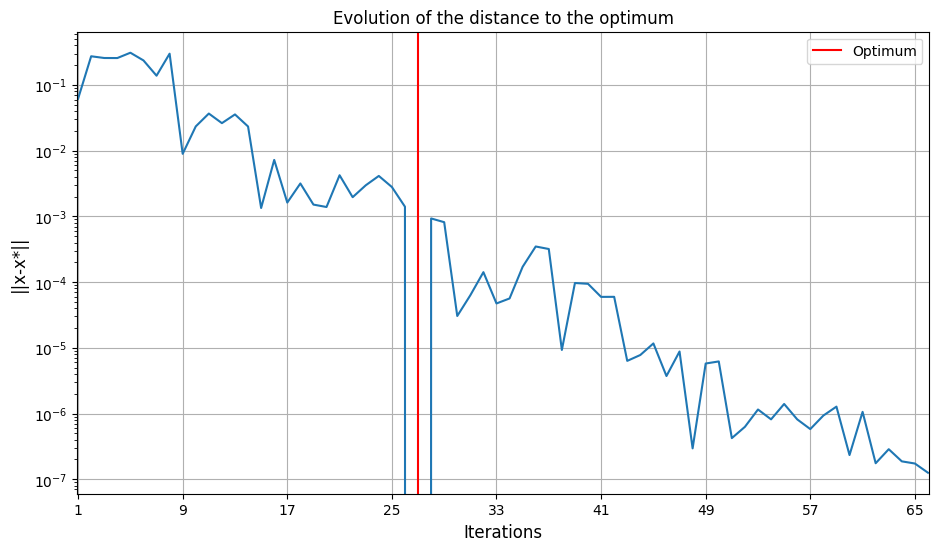

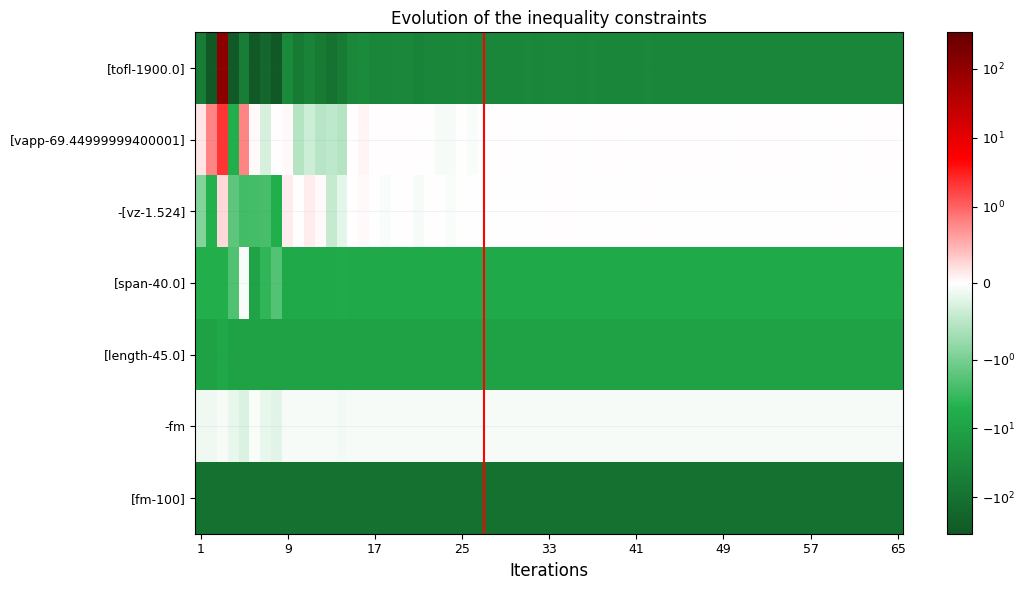

In [20]:
scenario_surrogate.post_process(post_name="OptHistoryView", save=False, show=True)

In [21]:
r2 = surrogate_discipline.get_error_measure("R2Measure")

In [22]:
r2.compute_cross_validation_measure(as_dict=True)

{'fm': array([0.95714011]),
 'length': array([1.]),
 'mtom': array([0.97803917]),
 'span': array([0.99661798]),
 'tofl': array([0.89989418]),
 'vapp': array([0.98378212]),
 'vz': array([0.98662742])}

In [23]:
r2.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.95395266]),
 'length': array([1.]),
 'mtom': array([0.97445752]),
 'span': array([0.99839314]),
 'tofl': array([0.93876024]),
 'vapp': array([0.99599425]),
 'vz': array([0.94261092])}

In [24]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")

In [25]:
rmse.compute_learning_measure(as_dict=True)

{'fm': array([0.00732052]),
 'length': array([8.40725503e-15]),
 'mtom': array([502.48961061]),
 'span': array([0.08047483]),
 'tofl': array([58.06575313]),
 'vapp': array([0.25283162]),
 'vz': array([1.02500726])}

In [26]:
design_space_pb1

Name,Lower bound,Value,Upper bound,Type
slst,100000,150000,200000,float
n_pax,120,150,180,float
area,100,180,200,float
ar,5,9,20,float


In [27]:
scenario = MDOScenario(l_disciplines, "mtom", design_space_pb1, formulation_name="MDF")
scenario.add_constraint("tofl", constraint_type="ineq", positive=False,value=convert_from("m", 1900))
scenario.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from("kt", 135))
scenario.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from("ft/min", 300))
scenario.add_constraint("span", constraint_type="ineq", positive=False, value=convert_from("m", 40))
scenario.add_constraint("length", constraint_type="ineq", positive=False, value=convert_from("m", 45))
scenario.add_constraint("fm", constraint_type="ineq", positive=True, value=0)
scenario.add_constraint("fm", constraint_type="ineq", positive=False, value=100)
design_space_pb1 = DesignSpacePB1()

In [28]:
#Vérification si le x optimal vérifie les contraintes (possible que non avec le model surrogate)
scenario.execute(algo_name="CustomDOE", samples=scenario_surrogate.optimization_result.x_opt.reshape(1, -1))

    INFO - 17:36:40: *** Start MDOScenario execution ***
    INFO - 17:36:40: MDOScenario
    INFO - 17:36:40:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:36:40:    MDO formulation: MDF
    INFO - 17:36:40: Optimization problem:
    INFO - 17:36:40:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:36:40:    with respect to ar, area, n_pax, slst
    INFO - 17:36:40:    subject to constraints:
    INFO - 17:36:40:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:36:40:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:36:40:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:36:40:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:36:40:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:36:40:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:36:40:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:36:40:    over the design space:
    INFO 

In [29]:
from gemseo_oad_training.utils import draw_aircraft
dict_result = scenario_surrogate.optimization_result.x_opt_as_dict
import re
length_val = None
span_val = None

for key, val in scenario_surrogate.optimization_result.constraint_values.items():
    match = re.search(r'\[(\w+)-([\d.]+)\]', key)
    if match:
        var_name, constraint_str = match.groups()
        constraint = float(constraint_str)
        real_value = val + constraint  # valeur réelle = valeur + contrainte
        if var_name == "length":
            length_val = real_value
        elif var_name == "span":
            span_val = real_value

length_mean = length_val if length_val else None
span_mean = span_val if span_val else None

print("Valeur réelle moyenne de length :", length_val)
print("Valeur réelle moyenne de span   :", span_val)

Valeur réelle moyenne de length : 34.75
Valeur réelle moyenne de span   : 32.69220834180064


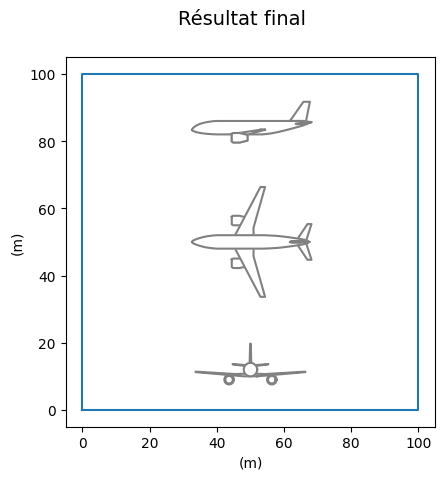

In [30]:
draw_aircraft(area=dict_result["area"][0],slst=dict_result["slst"][0], n_pax=dict_result["n_pax"][0],length=length_val, span=span_val, title="Résultat final")